## Source

Analysis and Scenario Development in Uganda’s Transport Sector  
- Private and public: Table 4-3, page 43.  
- Rail: Table 5-2, page 48.  
- Water: Table 6-2, page 52.  
- Aviation: Table 7-1, page 55.

### Aviation computation

Estimated Passenger-Kilometers (PKM) for International Aviation Departures in Uganda (2015–2018).

**Data Source:**  
* Number of domestic departing and arriving passengers per year (Table 7-1).  
* Number of international departing passengers per year (Table 7-1).  
* Assumption: Each international flight has an average travel distance of 2,500 km. And each domestic flight has an average travel distance of 300 km.

**Formula:**  
* PKM = Number of passengers × Average Distance per Departure (km)


In [1]:
import numpy as np
import pandas as pd
import os
from utils.utils import EDAUtils, TransportUtils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
edau = EDAUtils()
tu = TransportUtils()

In [4]:
# Set up paths
CURRENT_DIR_PATH = os.getcwd()
OUTPUT_DATA_DIR_PATH = os.path.join(CURRENT_DIR_PATH, "output_data")
INPUT_DATA_DIR_PATH = os.path.join(CURRENT_DIR_PATH, "input_data")

In [5]:
# Load population data
POPULATION_DATA_PATH = os.path.join(OUTPUT_DATA_DIR_PATH, "POPULATION.csv")
pop_df = pd.read_csv(POPULATION_DATA_PATH)

# Filter for the years 2015 to 2050
pop_df = pop_df[(pop_df['year'] >= 2015) & (pop_df['year'] <= 2050)]
pop_df = pop_df.reset_index(drop=True)
pop_df.head()

,year,population_gnrl_rural,population_gnrl_urban
0,2015,27415805,7922107
1,2016,28126956,8404570
2,2017,28903581,8925631
3,2018,29672226,9464281
4,2019,30457624,10028890


In [6]:
# Create pop_total column
pop_df['pop_total'] = pop_df['population_gnrl_rural'] + pop_df['population_gnrl_urban']
pop_df.head()

,year,population_gnrl_rural,population_gnrl_urban,pop_total
0,2015,27415805,7922107,35337912
1,2016,28126956,8404570,36531526
2,2017,28903581,8925631,37829212
3,2018,29672226,9464281,39136507
4,2019,30457624,10028890,40486514


In [7]:
pop_df.tail()

,year,population_gnrl_rural,population_gnrl_urban,pop_total
31,2046,38769171,28301495,67070666
32,2047,38877625,29165895,68043520
33,2048,38966634,30038289,69004923
34,2049,39030689,30913903,69944592
35,2050,39070478,31792509,70862987


In [8]:
# Keep only pop_total col
trde_passenger_df = pop_df[['year', 'pop_total']].copy()
trde_passenger_df.head()

,year,pop_total
0,2015,35337912
1,2016,36531526
2,2017,37829212
3,2018,39136507
4,2019,40486514


In [9]:
# Load gdp data
gdp_df = pd.read_csv(os.path.join(OUTPUT_DATA_DIR_PATH, "gdp_mmm_usd.csv"))
gdp_df.head()

,year,gdp_mmm_usd
0,1982,4.983495
1,1983,5.269775
2,1984,5.251612
3,1985,5.077973
4,1986,5.097782


In [10]:
trde_passenger_df = trde_passenger_df.merge(gdp_df[["year", "gdp_mmm_usd"]], on='year', how='left')
trde_passenger_df.head()

,year,pop_total,gdp_mmm_usd
0,2015,35337912,32.387184
1,2016,36531526,33.935615
2,2017,37829212,34.998277
3,2018,39136507,37.204541
4,2019,40486514,39.600047


In [11]:
# raw inputs
private_passenger_trde = 41.81e9
public_passenger_trde  = 69.36e9

rail_passenger_trde = {
    2016: 342_230,
    2017: 174_824,
    2018: 473_757,
    2019: 437_398,
    2020: 160_672
}

inland_water_passenger_trde = {2019: 17_252_769}

# raw inputs
domestic_passengers_arrivals = {
    2015: 7634,
    2016: 7350,
    2017: 9539,
    2018: 13798
}

domestic_passengers_departures = {
    2015: 7300,
    2016: 6816,
    2017: 9285,
    2018: 12982
}

international_passengers_departures = {
    2015: 690962,
    2016: 703649,
    2017: 757360,
    2018: 849034
}

aviation_passenger_trde = tu.compute_passenger_km(domestic_passengers_arrivals, domestic_passengers_departures, international_passengers_departures)
aviation_passenger_trde

{2015: 1731885200, 2016: 1763372300, 2017: 1899047200, 2018: 2130619000}

In [12]:
base_year = 2019

# Get base population and PKMs
base_pop = trde_passenger_df.loc[trde_passenger_df['year'] == base_year, 'pop_total'].values[0]
base_private_pkms = private_passenger_trde
base_public_pkms = public_passenger_trde
base_regional_pkms = (
    rail_passenger_trde.get(base_year, 0)
    + inland_water_passenger_trde.get(base_year, 0)
    + aviation_passenger_trde.get(2018, 0)
)

# Set GDP scaling factor
gdp_scaling = trde_passenger_df.loc[trde_passenger_df['year'] == base_year, 'gdp_mmm_usd'].values[0]

In [13]:
# Scale by pop and gdp
trde_passenger_df['deminit_trde_private_and_public_passenger_km'] = (
    (base_private_pkms + base_public_pkms)
    * (trde_passenger_df['pop_total'] / base_pop)
    * (trde_passenger_df['gdp_mmm_usd'] / gdp_scaling)
)

trde_passenger_df['deminit_trde_regional_passenger_km'] = (
    base_regional_pkms
    * (trde_passenger_df['pop_total'] / base_pop)
    * (trde_passenger_df['gdp_mmm_usd'] / gdp_scaling)
)

In [14]:
trde_passenger_df.head()

,year,pop_total,gdp_mmm_usd,deminit_trde_private_and_public_passenger_km,deminit_trde_regional_passenger_km
0,2015,35337912,32.387184,7.935889e+10,1.533574e+09
1,2016,36531526,33.935615,8.596171e+10,1.661171e+09
2,2017,37829212,34.998277,9.180270e+10,1.774045e+09
3,2018,39136507,37.204541,1.009624e+11,1.951051e+09
4,2019,40486514,39.600047,1.111700e+11,2.148309e+09


In [15]:
trde_passenger_df.tail()

,year,pop_total,gdp_mmm_usd,deminit_trde_private_and_public_passenger_km,deminit_trde_regional_passenger_km
31,2046,67070666,273.741762,1.273079e+12,2.460166e+10
32,2047,68043520,295.175742,1.392672e+12,2.691275e+10
33,2048,69004923,318.288002,1.522937e+12,2.943005e+10
34,2049,69944592,343.209953,1.664545e+12,3.216657e+10
35,2050,70862987,370.083292,1.818446e+12,3.514064e+10


<Axes: >

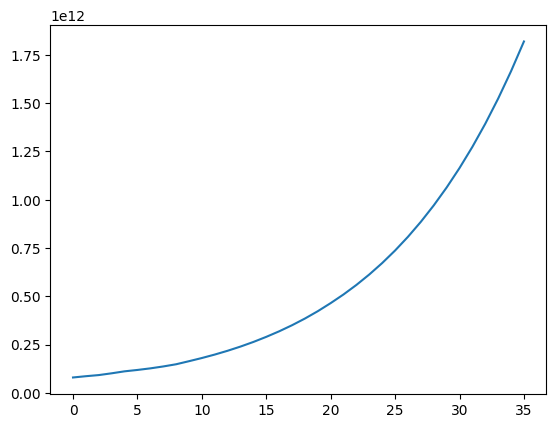

In [16]:
trde_passenger_df.deminit_trde_private_and_public_passenger_km.plot()

<Axes: >

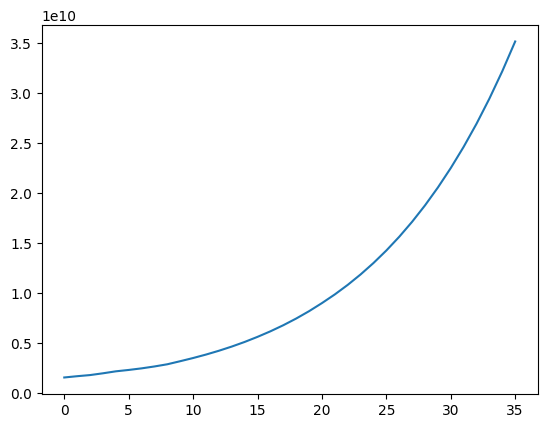

In [17]:
trde_passenger_df.deminit_trde_regional_passenger_km.plot()

In [18]:
trde_passenger_df["deminit_trde_private_and_public_per_capita_passenger_km"] = trde_passenger_df["deminit_trde_private_and_public_passenger_km"] / trde_passenger_df["pop_total"]
trde_passenger_df["deminit_trde_regional_per_capita_passenger_km"] = trde_passenger_df["deminit_trde_regional_passenger_km"] / trde_passenger_df["pop_total"]

In [19]:
# Keep only deminit columns and year columns
trde_passenger_df = trde_passenger_df[["year", "deminit_trde_private_and_public_per_capita_passenger_km", 
         "deminit_trde_regional_per_capita_passenger_km"]]

In [20]:
trde_passenger_df.head()

,year,deminit_trde_private_and_public_per_capita_passenger_km,deminit_trde_regional_per_capita_passenger_km
0,2015,2245.715333,43.397417
1,2016,2353.082989,45.472248
2,2017,2426.767560,46.896168
3,2018,2579.749137,49.852467
4,2019,2745.852607,53.062340


In [21]:
trde_passenger_df.tail()

,year,deminit_trde_private_and_public_per_capita_passenger_km,deminit_trde_regional_per_capita_passenger_km
31,2046,18981.152447,366.802049
32,2047,20467.376684,395.522650
33,2048,22069.972278,426.492073
34,2049,23798.051107,459.886402
35,2050,25661.438509,495.895508


## Validation

In [22]:
og_df = pd.read_csv(os.path.join(INPUT_DATA_DIR_PATH, "sisepuede_raw_global_inputs_uganda.csv"))
og_df = og_df[["deminit_trde_private_and_public_per_capita_passenger_km", 
         "deminit_trde_regional_per_capita_passenger_km"]]
og_df.head()

,deminit_trde_private_and_public_per_capita_passenger_km,deminit_trde_regional_per_capita_passenger_km
0,90.416780,13.224175
1,90.835038,13.124486
2,90.835038,13.124486
3,90.835038,13.124486
4,90.835038,13.124486


<Axes: >

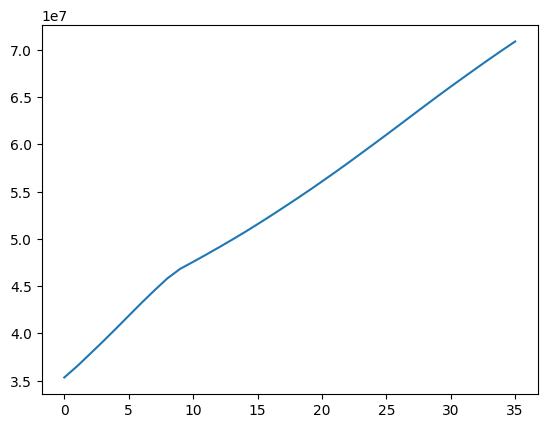

In [23]:
pop_df["pop_total"].plot()

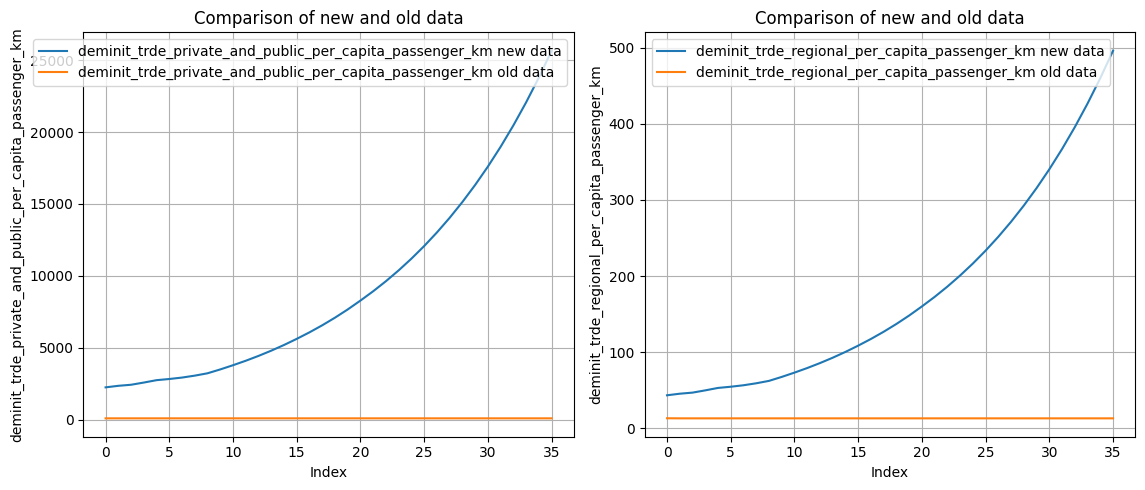

In [24]:
edau.compare_variables(trde_passenger_df,
                       og_df,
                       ["deminit_trde_private_and_public_per_capita_passenger_km",
                        "deminit_trde_regional_per_capita_passenger_km"]
                        )

In [25]:
trde_passenger_df.to_csv(os.path.join(OUTPUT_DATA_DIR_PATH, "deminit_trde_per_capita_passenger_km.csv"), index=False)